To build an image classifier for identifying whether the vehicle is an emergency vehicle or not

we'll be using the images available in the AV computer vision hackathon
https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/#ProblemStatement

In [1]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np

#we have different packages for reading the images such as opencv, PIL. Here we'll use PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
print('The current directory is:', os.getcwd())

The current directory is: /content


In [4]:
#let's traverse to the path where images are stored
os.chdir('/content/drive/MyDrive/AV - Image Recognition/')

In [5]:
print('The current directory is:', os.getcwd())

The current directory is: /content/drive/MyDrive/AV - Image Recognition


In [6]:
#The train and test csv files contain the names of the images with the corresponding target label
#let's download the train and test sheets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_vc2kHdQ.csv')

In [7]:
#displaying the file structure of the train file
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [8]:
#the unique number of labels
train_df['emergency_or_not'].value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


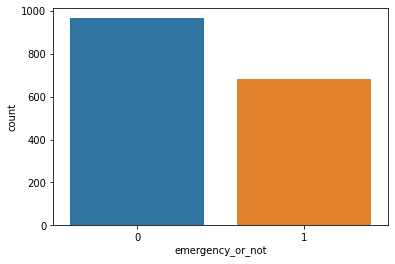

In [9]:
sns.countplot(train_df['emergency_or_not'])

965 - Non emergency vehicles
681 - Emergency vehicles

A sample Non Emergency Vehicle


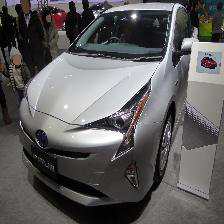

In [10]:
#Let's display some images of Non-emergency vehicles
img = Image.open('images/1503.jpg')

print('A sample Non Emergency Vehicle')
img

A sample Emergency Vehicle


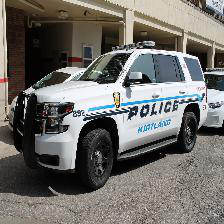

In [11]:
#Let's display some images of Non-emergency vehicles
img1 = Image.open('images/45.jpg')

print('A sample Emergency Vehicle')
img1

In [12]:
#displaying test file
test_df.head(10)

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg
5,350.jpg
6,1557.jpg
7,111.jpg
8,1952.jpg
9,1466.jpg


Test file image


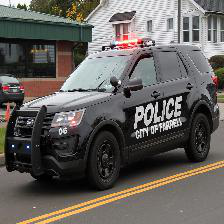

In [13]:
#print some of the images from the test file
img = Image.open('images/350.jpg')

print('Test file image')
img

Test file image


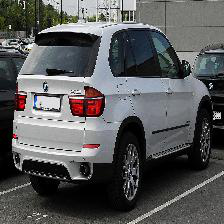

In [14]:
#print some of the images from the test file
img = Image.open('images/1557.jpg')

print('Test file image')
img

In [15]:
#we can convert the image into pixel values using opencv library
img = cv2.imread('images/1557.jpg')

In [16]:
img.shape

(224, 224, 3)

The shape of the input records is 224 x 224 x 3(RGB channels). We can try any of the pretrained CNNs for the classification. 

In [17]:
#lets read all the images from the train and test using opencv2
train_data = []
for i, row in train_df.iterrows():
  image_name = row['image_names']
  path = 'images/' + image_name
  data = cv2.imread(path)
  train_data.append(data)

In [18]:
train_x = np.array(train_data)

In [19]:
train_y = np.array(train_df['emergency_or_not'])

In [20]:
print('The shape of the train input:', train_x.shape)
print('The shape of the train output:', train_y.shape)

The shape of the train input: (1646, 224, 224, 3)
The shape of the train output: (1646,)


In [21]:
#lets read all the images from test using opencv2
test_data = []
for i, row in test_df.iterrows():
  image_name = row['image_names']
  path = 'images/' + image_name
  data = cv2.imread(path)
  test_data.append(data)

In [22]:
test_x = np.array(test_data)

In [23]:
test_x.shape

(706, 224, 224, 3)

In [24]:
#Let's use ResNet50 to train the model, and the pretrained weights correspond to imagenet dataset
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model

One point to be noted here:

The final layer has been removed. Since the model is trained on the imagenet dataset, the top layer is the softmax with 1000 nodes corresponding the total number of classes. 

In [25]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
    
restnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

We have two options here. (i) Either we can train the model as such by only new layers at the top of the resnet. (ii) Or we can train last couple of layers (i.e) to allow the model to adjust the learnable parameters in some layers. 

Let's try both.

In [26]:
#option1 - Not altering the weights only adding the new layers at the end
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_finetuned = Sequential()
model_finetuned.add(restnet)
model_finetuned.add(Dense(512, activation='relu', input_dim=100352))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(512, activation='relu'))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(1, activation='sigmoid'))
adam = optimizers.Adam(lr = 0.001)
model_finetuned.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpoint = ModelCheckpoint("model.best.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)
stop = EarlyStopping(monitor="val_accuracy", patience=5)

callbacklist = [checkpoint, reduce_lr, stop]

model_finetuned.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 75,231,617
Trainable params: 51,643,905
Non-trainable params: 23,587,712
___________________________________

In [27]:
model_finetuned.fit(train_x, train_y, batch_size=32, epochs=20, validation_split=0.2, verbose=1,callbacks=callbacklist)

Epoch 1/20
42/42 [==============================] - 37s 103ms/step - loss: 8.7343 - accuracy: 0.7241 - val_loss: 1.6840 - val_accuracy: 0.9152

Epoch 00001: val_accuracy improved from -inf to 0.91515, saving model to model.best.h5
Epoch 2/20
42/42 [==============================] - 3s 71ms/step - loss: 1.2109 - accuracy: 0.9299 - val_loss: 1.2985 - val_accuracy: 0.9273

Epoch 00002: val_accuracy improved from 0.91515 to 0.92727, saving model to model.best.h5
Epoch 3/20
42/42 [==============================] - 3s 72ms/step - loss: 0.7329 - accuracy: 0.9339 - val_loss: 1.5235 - val_accuracy: 0.9242

Epoch 00003: val_accuracy did not improve from 0.92727
Epoch 4/20
42/42 [==============================] - 3s 71ms/step - loss: 0.8954 - accuracy: 0.9530 - val_loss: 2.1105 - val_accuracy: 0.8909

Epoch 00004: val_accuracy did not improve from 0.92727
Epoch 5/20
42/42 [==============================] - 3s 70ms/step - loss: 0.2086 - accuracy: 0.9841 - val_loss: 1.6123 - val_accuracy: 0.9364

E

In [28]:
predict = model_finetuned.predict(test_x)

In [29]:
predict[1]

array([1.], dtype=float32)

In [30]:
test_df.iloc[1]

image_names    668.jpg
Name: 1, dtype: object

Test file image


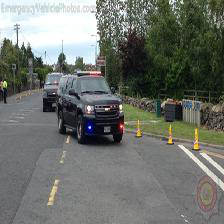

In [31]:
img = Image.open('images/668.jpg')

print('Test file image')
img

The above picture is an Emergency vehicle.

In [32]:
predict[2]

array([0.], dtype=float32)

In [33]:
test_df.iloc[2]

image_names    2082.jpg
Name: 2, dtype: object

Test file image


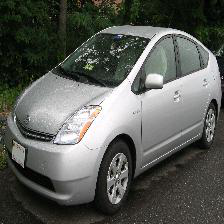

In [34]:
img = Image.open('images/2082.jpg')

print('Test file image')
img

#### Option2 - Making some of the last layers trainable

In [36]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
    
restnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [52]:
restnet.trainable = True
set_trainable = False
for layer in restnet.layers:  
  if layer.name in ['conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu',
                    'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu',
                    'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add',
                    'conv5_block3_out', 'flatten_2']:
      layer.trainable = True
  else:
      layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in restnet.layers]
layer_df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [53]:
layer_df[layer_df['Layer Trainable'] == True]

,Layer Type,Layer Name,Layer Trainable
165,<tensorflow.python.keras.layers.convolutional....,conv5_block3_1_conv,True
166,<tensorflow.python.keras.layers.normalization_...,conv5_block3_1_bn,True
167,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_1_relu,True
168,<tensorflow.python.keras.layers.convolutional....,conv5_block3_2_conv,True
169,<tensorflow.python.keras.layers.normalization_...,conv5_block3_2_bn,True
170,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_2_relu,True
171,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization_...,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,True
174,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_out,True


As we can see some of the layers are trainable now. 

In [54]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_finetuned = Sequential()
model_finetuned.add(restnet)
model_finetuned.add(Dense(512, activation='relu', input_dim=100352))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(512, activation='relu'))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(1, activation='sigmoid'))
adam = optimizers.Adam(lr = 0.001)
model_finetuned.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

checkpoint = ModelCheckpoint("model.best.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)
stop = EarlyStopping(monitor="val_accuracy", patience=5)

callbacklist = [checkpoint, reduce_lr, stop]

model_finetuned.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100352)            23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 75,231,617
Trainable params: 56,109,569
Non-trainable params: 19,122,048
_________________________________

In [55]:
model_finetuned.fit(train_x, train_y, batch_size=32, epochs=20, validation_split=0.2, verbose=1,callbacks=callbacklist)

Epoch 1/20
42/42 [==============================] - 7s 97ms/step - loss: 5.5823 - accuracy: 0.7638 - val_loss: 3.2097 - val_accuracy: 0.8333

Epoch 00001: val_accuracy improved from -inf to 0.83333, saving model to model.best.h5
Epoch 2/20
42/42 [==============================] - 3s 77ms/step - loss: 0.5737 - accuracy: 0.9310 - val_loss: 3.1279 - val_accuracy: 0.8909

Epoch 00002: val_accuracy improved from 0.83333 to 0.89091, saving model to model.best.h5
Epoch 3/20
42/42 [==============================] - 3s 77ms/step - loss: 0.3076 - accuracy: 0.9671 - val_loss: 2.4336 - val_accuracy: 0.9394

Epoch 00003: val_accuracy improved from 0.89091 to 0.93939, saving model to model.best.h5
Epoch 4/20
42/42 [==============================] - 3s 77ms/step - loss: 0.3847 - accuracy: 0.9647 - val_loss: 3.5776 - val_accuracy: 0.9212

Epoch 00004: val_accuracy did not improve from 0.93939
Epoch 5/20
42/42 [==============================] - 3s 76ms/step - loss: 0.1343 - accuracy: 0.9883 - val_loss: